First I followed <a href="https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8">this</a> to build a model.  This ended up (after automatic feature selection--recursive feature elimination) to not use almost any demographic data to predict high custody level.  

Next, I followed <a href="https://pythonfordatascienceorg.wordpress.com/logistic-regression-python/">this</a> to see if this feature selected model satistifed conditions.

Things I want to do:
1. do the same thing but with manual feature selection (done)
1. do the same thing but with a different number of features to be selected
1. figure out why the data set shrunk so much based on the confusion matrix being much smaller than the original one (done--confusion matrix just based on training data)
1. do the same but with overrides.  Override yes/no and override up yes/no.
1. do the same but with only 2017 data

## Setting up the notebook

In [1]:
import sys
sys.path.append("../../src")
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from heatmap import heatmap
import statsmodels.formula.api as smf
import bioinfokit

In [3]:
plt.style.use('ggplot')

In [4]:
from math391.models.logit_models import LogitModelRunner
from math391.preprocessing import preprocess_for_logit
from math391.plotting import roc_plot

In [5]:
%matplotlib inline

from project import rf_models, preprocessing

df = pd.read_csv("../../data/initial_custody_2017_gsprs.csv", low_memory=False)

df['high_ic_instit_adj'] = np.where(df['ic_institut_adj']>2, 1, 0)
df['ic_override_up'] = np.where(df['ic_ovride_cust_lvl']-df['ic_custdy_level']>0,1,0)
df['high_ic'] = np.where(df['ic_custdy_level']>3, 1, 0)


# preprocessing
data = preprocessing.preprocess_input_vars(df)
data = data[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        #"ic_custdy_level",
        "prior_commits",
        "ic_institut_adj",
        "escape_hist_1",
        "escape_hist_2",
        "escape_hist_3",
        "escape_hist_4",
        "escape_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed",
        "high_ic_instit_adj",
        "high_ic"
    ]
]
data = data.dropna()

df_ic_all = data

---

## Data exploration

In [6]:
df_ic_all['high_ic'].value_counts()

1    7750
0    6070
Name: high_ic, dtype: int64

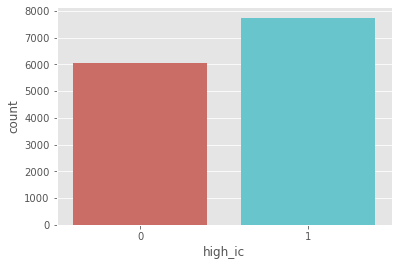

In [7]:
sns.countplot(x='high_ic', data=df_ic_all, palette='hls')
plt.show()

In [9]:
count_hi = len(df_ic_all[df_ic_all['high_ic']==0])
count_lo = len(df_ic_all[df_ic_all['high_ic']==1])
pct_hi = count_hi/(count_hi+count_lo)
print("percentage of high lev is", pct_hi*100)
pct_lo = count_lo/(count_hi+count_lo)
print("percentage of low lev is", pct_lo*100)

percentage of high lev is 43.92185238784371
percentage of low lev is 56.07814761215629


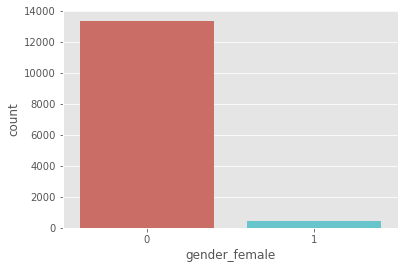

In [10]:
sns.countplot(x='gender_female', data=df_ic_all, palette='hls')
plt.show()

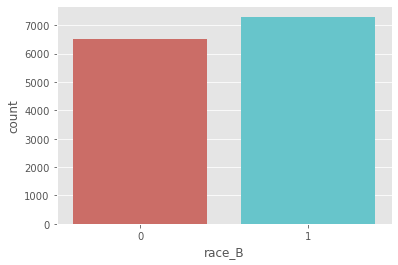

In [11]:
sns.countplot(x='race_B', data=df_ic_all, palette='hls')
plt.show()

###  See how quantitative variables vary with custody level

In [12]:
df_ic_all.groupby('high_ic').mean()['prior_commits']

high_ic
0    3.226030
1    3.330968
Name: prior_commits, dtype: float64

In [13]:
df_ic_all.groupby('high_ic').mean()['off_1_gs_max']

high_ic
0    10.914168
1    12.455613
Name: off_1_gs_max, dtype: float64

In [14]:
df_ic_all.groupby('high_ic').mean()['off_1_prs_max']

high_ic
0    2.363591
1    2.648839
Name: off_1_prs_max, dtype: float64

In [15]:
df_ic_all.groupby('high_ic').mean()['ic_institut_adj']

high_ic
0    2.299671
1    3.816258
Name: ic_institut_adj, dtype: float64

###  See how quantitative variables vary with race_B

In [16]:
df_ic_all.groupby('race_B').mean()['ic_institut_adj']

race_B
0    2.950759
1    3.328174
Name: ic_institut_adj, dtype: float64

In [17]:
df_ic_all.groupby('race_B').mean()['off_1_prs_max']

race_B
0    2.400522
1    2.633406
Name: off_1_prs_max, dtype: float64

In [18]:
df_ic_all.groupby('race_B').mean()['off_1_gs_max']

race_B
0    11.149409
1    12.340364
Name: off_1_gs_max, dtype: float64

In [19]:
df_ic_all.groupby('race_B').mean()['prior_commits']

race_B
0    3.342997
1    3.232982
Name: prior_commits, dtype: float64

###  Visualizations

Text(0, 0.5, 'Count of people')

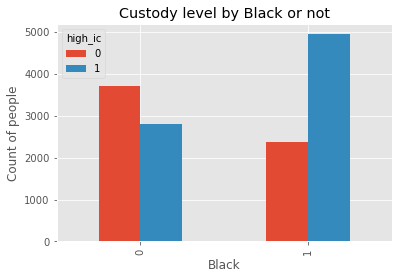

In [20]:
%matplotlib inline
pd.crosstab(df_ic_all.race_B,df_ic_all.high_ic).plot(kind='bar')
plt.title('Custody level by Black or not')
plt.xlabel('Black')
plt.ylabel('Count of people')


Text(0, 0.5, 'Proportion of people')

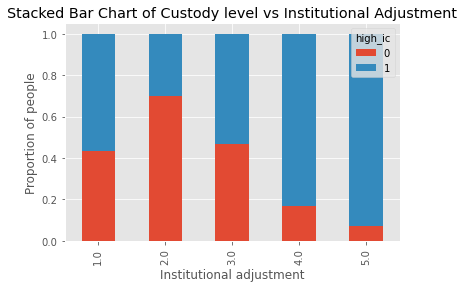

In [21]:
table=pd.crosstab(df_ic_all.ic_institut_adj,df_ic_all.high_ic)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Custody level vs Institutional Adjustment')
plt.xlabel('Institutional adjustment')
plt.ylabel('Proportion of people')


Text(0, 0.5, 'Proportion of people')

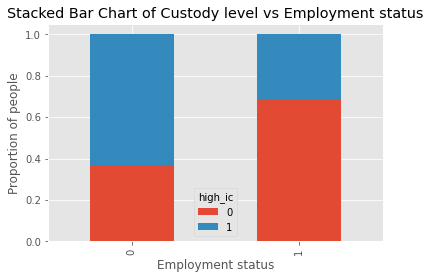

In [22]:
table=pd.crosstab(df_ic_all.employed,df_ic_all.high_ic)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Custody level vs Employment status')
plt.xlabel('Employment status')
plt.ylabel('Proportion of people')

Text(0, 0.5, 'Proportion of people')

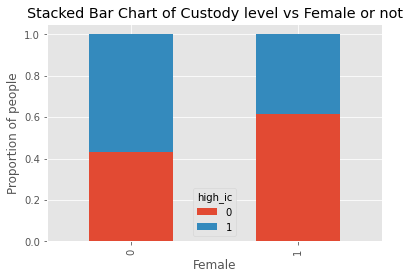

In [23]:
table=pd.crosstab(df_ic_all.gender_female,df_ic_all.high_ic)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Custody level vs Female or not')
plt.xlabel('Female')
plt.ylabel('Proportion of people')

---

## Recursive feature elimination

In [24]:
data_final = df_ic_all # make a copy

In [25]:
data_final_vars=data_final.columns.values.tolist()

In [26]:
yvars = ['high_ic']

In [27]:
Xvars = [i for i in data_final_vars if i not in yvars]

In [28]:
X = data_final.loc[:, data_final.columns != 'high_ic']
y = data_final.loc[:, data_final.columns == 'high_ic']

In [29]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=300) # increase the number of iterations to get convergence


In [30]:
rfe = RFE(logreg, n_features_to_select=8, step=1)
rfe = rfe.fit(X, y.values.ravel())

/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

In [31]:
print(rfe.support_)

[False  True False False False False False False False False False  True
 False False False  True  True  True  True  True  True False False]


In [32]:
zz= list(zip(Xvars,list(rfe.support_)))

In [33]:
ll = [a for (a,b) in zz if b]

In [34]:
ll

['age_gt_45',
 'ic_institut_adj',
 'escape_hist_4',
 'escape_hist_5',
 'mrt_stat_DIV',
 'mrt_stat_SEP',
 'mrt_stat_MAR',
 'mrt_stat_WID']

In [35]:
X = X[ll]


---

## Implementing the model

In [36]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.496312
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.276     
Dependent Variable: high_ic          AIC:              13734.0521
Date:               2021-09-29 09:53 BIC:              13794.3231
No. Observations:   13820            Log-Likelihood:   -6859.0   
Df Model:           7                LL-Null:          -9476.9   
Df Residuals:       13812            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
age_gt_45        -1.6687   0.0620 -26.9225 0.0000 -1.7901 -1.5472
ic_institut_adj   0.3771   0.0077  49.2291 0.0000  0.3621  0.3921


In [37]:
model_odds = pd.DataFrame(np.exp(result.params), columns= ['OR'])
model_odds['z-value']= result.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(result.conf_int())
model_odds

,OR,z-value,2.5%,97.5%
age_gt_45,0.188498,1.197615e-159,0.166936,0.212846
ic_institut_adj,1.458053,0.000000e+00,1.436326,1.480109
escape_hist_4,3.323122,8.554223e-37,2.759773,4.001466
escape_hist_5,6.014469,2.686413e-19,4.065810,8.897081
mrt_stat_DIV,0.118767,6.490911e-138,0.100495,0.140361
mrt_stat_SEP,0.110352,2.068819e-98,0.089882,0.135484
mrt_stat_MAR,0.163160,1.307146e-153,0.142613,0.186666
mrt_stat_WID,0.222237,3.572382e-15,0.152802,0.323226


## Model fitting

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())

LogisticRegression()

In [40]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.80


In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1568  225]
 [ 620 1733]]


In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79      1793
           1       0.89      0.74      0.80      2353

    accuracy                           0.80      4146
   macro avg       0.80      0.81      0.80      4146
weighted avg       0.81      0.80      0.80      4146



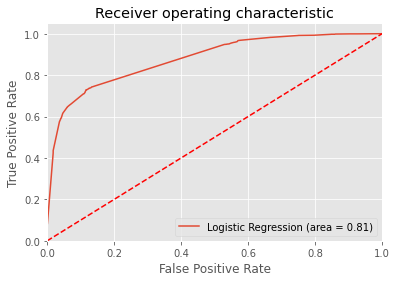

In [43]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

---

## Checking conditions

### Continuous IVs linearly related to log odds

In [44]:
#gre = sns.regplot(x= 'gre', y= 'admit', data= df, logistic= True).set_title("GRE Log Odds Linear Plot")
#gre.figure.savefig("gre log lin.png")

#gpa = sns.regplot(x= 'gpa', y= 'admit', data= df, logistic= True).set_title("GPA Log Odds Linear Plot")
#gpa.figure.savefig("gpa log lin.png")

# Don't have any continuous IVs after feature selection so this condition is trivially/vacuously met

### Assumption of Absence of Multicollinearity

In [45]:
X.corr()

,age_gt_45,ic_institut_adj,escape_hist_4,escape_hist_5,mrt_stat_DIV,mrt_stat_SEP,mrt_stat_MAR,mrt_stat_WID
age_gt_45,1.000000,-0.198507,0.030520,-0.040292,0.271554,0.068125,0.100037,0.116616
ic_institut_adj,-0.198507,1.000000,0.037038,0.083080,-0.114501,-0.059544,-0.094386,-0.039503
escape_hist_4,0.030520,0.037038,1.000000,0.045124,-0.004655,-0.008942,0.000252,0.009612
escape_hist_5,-0.040292,0.083080,0.045124,1.000000,-0.016482,-0.012668,-0.004189,-0.011525
mrt_stat_DIV,0.271554,-0.114501,-0.004655,-0.016482,1.000000,-0.067900,-0.102418,-0.034910
mrt_stat_SEP,0.068125,-0.059544,-0.008942,-0.012668,-0.067900,1.000000,-0.073604,-0.025089
mrt_stat_MAR,0.100037,-0.094386,0.000252,-0.004189,-0.102418,-0.073604,1.000000,-0.037843
mrt_stat_WID,0.116616,-0.039503,0.009612,-0.011525,-0.034910,-0.025089,-0.037843,1.000000


In [46]:
# Condition is satisfied because that's what RFE does (I think)

### Assumption of Lack of Outliers

In [47]:
#gpa_rank_box = sns.boxplot(data= df[['gpa', 'rank']]).set_title("GPA and Rank Box Plot")
#gpa_rank_box.figure.savefig("GPA and Rank Box Plot.png")

#gre_box = sns.boxplot(x= 'gre', data= df, orient= 'v').set_title("GRE Box Plot")
#gre_box.figure.savefig("GRE Box Plot.png")

# Again, no continuous IVs and so no outliers

###  Residuals

Based on <a href="https://www.pythonfordatascience.org/logistic-regression-python/#test_with_python">this</a>

/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


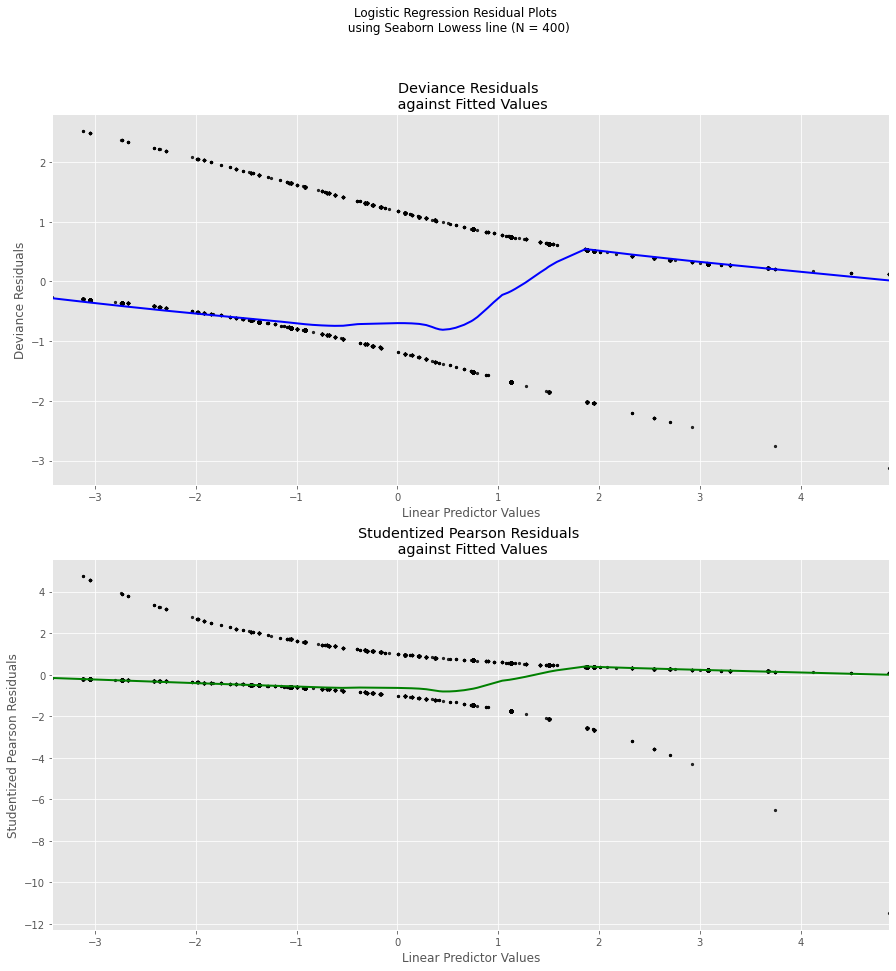

In [48]:
## Plotting multiple plots same figure
fig, (axL, axR) = plt.subplots(2, figsize=(15, 15))
plt.suptitle("Logistic Regression Residual Plots \n using Seaborn Lowess line (N = 400)")


# Deviance Residuals
sns.regplot(result.fittedvalues, result.resid_dev, ax= axL,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"b", "alpha":1, "lw":2}, lowess=True)

axL.set_title("Deviance Residuals \n against Fitted Values")
axL.set_xlabel("Linear Predictor Values")
axL.set_ylabel("Deviance Residuals")

# Studentized Pearson Residuals
sns.regplot(result.fittedvalues, result.resid_pearson, ax= axR,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"g", "alpha":1, "lw":2}, lowess=True)

axR.set_title("Studentized Pearson Residuals \n against Fitted Values")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Studentized Pearson Residuals")

plt.show()

In [49]:
# We see that the second line is pretty straight and has y-intercept close to 0

---

## Adding in other variables to control



In [50]:
data_control = data_final

Optimization terminated successfully.
         Current function value: 0.435310
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.365     
Dependent Variable: high_ic          AIC:              12063.9729
Date:               2021-09-29 09:54 BIC:              12184.5148
No. Observations:   13820            Log-Likelihood:   -6016.0   
Df Model:           15               LL-Null:          -9476.9   
Df Residuals:       13804            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
age_gt_45        -1.3108   0.0704 -18.6069 0.0000 -1.4489 -1.1727
ic_institut_adj   0.7270   0.0185  39.2805 0.0000  0.6907  0.7633


/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


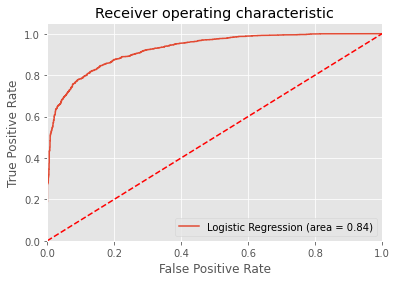

In [51]:
data_control_vars=data_final.columns.values.tolist()
yvars = ['high_ic']
Xvars = [i for i in data_final_vars if i not in y]
X = data_control.loc[:, data_control.columns != 'high_ic']
y = data_control.loc[:, data_control.columns == 'high_ic']
ll = ['age_gt_45',
 'ic_institut_adj',
 'escape_hist_1',
 'escape_hist_4',
 'escape_hist_5',
 'mrt_stat_DIV',
 'mrt_stat_SEP',
 'mrt_stat_MAR',
 'mrt_stat_WID',
 'employed']
ll.append('race_B')
ll.append('off_1_gs_max')
ll.append('off_1_prs_max')
ll.append('prior_commits')
ll.append('age_lt_25')
ll.append('gender_female')
X = X[ll]
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

model_odds = pd.DataFrame(np.exp(result.params), columns= ['OR'])
model_odds['z-value']= result.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(result.conf_int())
print(model_odds)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


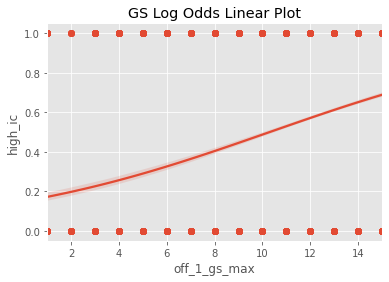

In [52]:
gs = sns.regplot(x= 'off_1_gs_max', y= 'high_ic', data= data_control, logistic= True).set_title("GS Log Odds Linear Plot")

plt.show()



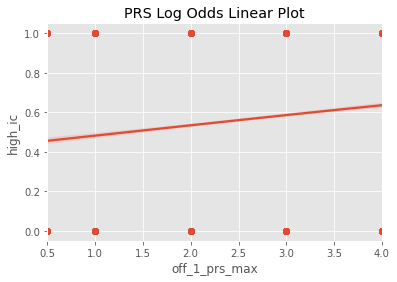

In [53]:
prs = sns.regplot(x= 'off_1_prs_max', y= 'high_ic', data= data_control, logistic= True).set_title("PRS Log Odds Linear Plot")

plt.show()

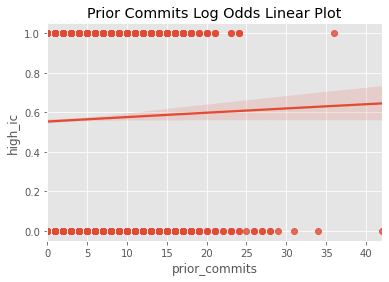

In [54]:
pc = sns.regplot(x= 'prior_commits', y= 'high_ic', data= data_control, logistic= True).set_title("Prior Commits Log Odds Linear Plot")

plt.show()

In [55]:
# should be looking for something consistent with an S-shaped curve
# these all seem to have it

In [56]:
data_control[ll].corr()

,age_gt_45,ic_institut_adj,escape_hist_1,escape_hist_4,escape_hist_5,mrt_stat_DIV,mrt_stat_SEP,mrt_stat_MAR,mrt_stat_WID,employed,race_B,off_1_gs_max,off_1_prs_max,prior_commits,age_lt_25,gender_female
age_gt_45,1.000000,-0.198507,0.036476,0.030520,-0.040292,0.271554,0.068125,0.100037,0.116616,0.114331,-0.103432,-0.097230,0.067206,0.203317,-0.249919,0.006164
ic_institut_adj,-0.198507,1.000000,-0.069811,0.037038,0.083080,-0.114501,-0.059544,-0.094386,-0.039503,-0.157653,0.141643,0.075736,-0.004466,-0.037940,0.238882,-0.012788
escape_hist_1,0.036476,-0.069811,1.000000,-0.273208,-0.164016,0.039969,0.022940,0.025101,0.019692,0.116087,-0.062309,0.104968,-0.122550,-0.334841,0.073570,0.023996
escape_hist_4,0.030520,0.037038,-0.273208,1.000000,0.045124,-0.004655,-0.008942,0.000252,0.009612,-0.030802,0.014316,-0.055733,0.037850,0.253162,-0.077898,-0.026452
escape_hist_5,-0.040292,0.083080,-0.164016,0.045124,1.000000,-0.016482,-0.012668,-0.004189,-0.011525,-0.035505,0.002186,-0.053057,-0.003058,0.029621,0.031411,-0.013529
mrt_stat_DIV,0.271554,-0.114501,0.039969,-0.004655,-0.016482,1.000000,-0.067900,-0.102418,-0.034910,0.112184,-0.177678,-0.035686,-0.029034,0.036463,-0.171299,0.002701
mrt_stat_SEP,0.068125,-0.059544,0.022940,-0.008942,-0.012668,-0.067900,1.000000,-0.073604,-0.025089,0.056770,-0.069984,-0.025547,-0.005044,0.018171,-0.112104,0.018422
mrt_stat_MAR,0.100037,-0.094386,0.025101,0.000252,-0.004189,-0.102418,-0.073604,1.000000,-0.037843,0.138024,-0.069875,0.001788,0.016936,0.015867,-0.150296,0.012111
mrt_stat_WID,0.116616,-0.039503,0.019692,0.009612,-0.011525,-0.034910,-0.025089,-0.037843,1.000000,0.042457,-0.043925,0.012377,-0.010303,0.012312,-0.060120,0.063709
employed,0.114331,-0.157653,0.116087,-0.030802,-0.035505,0.112184,0.056770,0.138024,0.042457,1.000000,-0.127717,-0.034391,-0.039653,-0.058335,-0.181614,-0.001282


In [57]:
# all are in [-.3, .3]

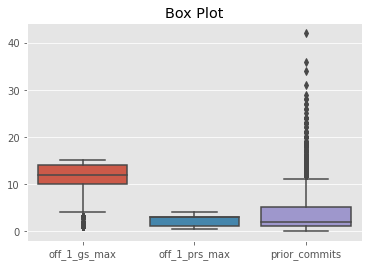

In [58]:
gs_rank_box = sns.boxplot(data= data_control[ll][['off_1_gs_max', 'off_1_prs_max','prior_commits']]).set_title("Box Plot")

plt.show()

In [59]:
data_control['prior_commits'].describe()

count    13820.000000
mean         3.284877
std          3.399891
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         42.000000
Name: prior_commits, dtype: float64

In [61]:
outlier = data_control[data_control['prior_commits']>11]

In [62]:
outlier.describe()

,gender_female,age_gt_45,age_lt_25,race_B,race_A,race_H,race_I,race_O,off_1_prs_max,off_1_gs_max,...,escape_hist_3,escape_hist_4,escape_hist_5,mrt_stat_DIV,mrt_stat_SEP,mrt_stat_MAR,mrt_stat_WID,employed,high_ic_instit_adj,high_ic
count,460.000000,460.000000,460.000000,460.000000,460.0,460.000000,460.000000,460.0,460.000000,460.000000,...,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,0.032609,0.469565,0.008696,0.467391,0.0,0.065217,0.002174,0.0,2.921739,9.576087,...,0.319565,0.271739,0.028261,0.141304,0.058696,0.100000,0.021739,0.184783,0.397826,0.408696
std,0.177804,0.499616,0.092945,0.499479,0.0,0.247178,0.046625,0.0,0.933733,3.278748,...,0.466816,0.445340,0.165898,0.348714,0.235310,0.300327,0.145989,0.388544,0.489982,0.492128
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.500000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,3.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,3.000000,8.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,4.000000,12.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,4.000000,15.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
data_control.describe()

,gender_female,age_gt_45,age_lt_25,race_B,race_A,race_H,race_I,race_O,off_1_prs_max,off_1_gs_max,...,escape_hist_3,escape_hist_4,escape_hist_5,mrt_stat_DIV,mrt_stat_SEP,mrt_stat_MAR,mrt_stat_WID,employed,high_ic_instit_adj,high_ic
count,13820.000000,13820.000000,13820.000000,13820.000000,13820.000000,13820.000000,13820.000000,13820.000000,13820.000000,13820.000000,...,13820.000000,13820.000000,13820.000000,13820.000000,13820.000000,13820.000000,13820.000000,13820.000000,13820.00000,13820.000000
mean,0.031983,0.161722,0.244573,0.528292,0.002315,0.105065,0.000941,0.003473,2.523553,11.778582,...,0.238712,0.074385,0.028148,0.086324,0.046527,0.099928,0.012735,0.220116,0.47576,0.560781
std,0.175960,0.368209,0.429849,0.499217,0.048065,0.306648,0.030657,0.058834,1.167841,3.074661,...,0.426312,0.262406,0.165400,0.280852,0.210631,0.299914,0.112133,0.414340,0.49943,0.496310
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,12.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,14.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,15.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [64]:
  460/13820
# this percent of outliers for prior_commits

0.03328509406657019

/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


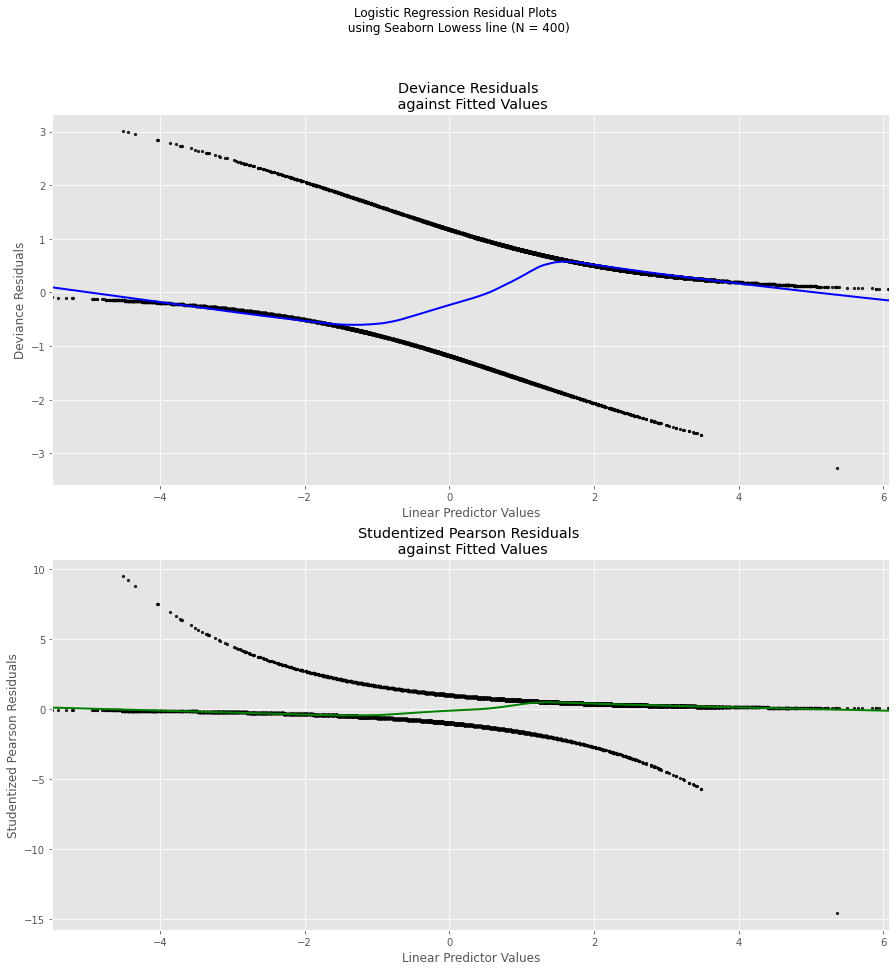

In [65]:
## Plotting multiple plots same figure
fig, (axL, axR) = plt.subplots(2, figsize=(15, 15))
plt.suptitle("Logistic Regression Residual Plots \n using Seaborn Lowess line (N = 400)")


# Deviance Residuals
sns.regplot(result.fittedvalues, result.resid_dev, ax= axL,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"b", "alpha":1, "lw":2}, lowess=True)

axL.set_title("Deviance Residuals \n against Fitted Values")
axL.set_xlabel("Linear Predictor Values")
axL.set_ylabel("Deviance Residuals")

# Studentized Pearson Residuals
sns.regplot(result.fittedvalues, result.resid_pearson, ax= axR,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"g", "alpha":1, "lw":2}, lowess=True)

axR.set_title("Studentized Pearson Residuals \n against Fitted Values")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Studentized Pearson Residuals")

plt.show()

In [66]:
# The second graph looks flat and to have a y-intercept of close to 0 and so this condition is met

In [67]:
ll

['age_gt_45',
 'ic_institut_adj',
 'escape_hist_1',
 'escape_hist_4',
 'escape_hist_5',
 'mrt_stat_DIV',
 'mrt_stat_SEP',
 'mrt_stat_MAR',
 'mrt_stat_WID',
 'employed',
 'race_B',
 'off_1_gs_max',
 'off_1_prs_max',
 'prior_commits',
 'age_lt_25',
 'gender_female']

---

## Repeated but for overrides



In [78]:
#ll.append('ic_override_up')
# 
##ll.remove('ic_override_up')
##ll

['age_gt_45',
 'ic_institut_adj',
 'escape_hist_1',
 'escape_hist_4',
 'escape_hist_5',
 'mrt_stat_DIV',
 'mrt_stat_SEP',
 'mrt_stat_MAR',
 'mrt_stat_WID',
 'employed',
 'race_B',
 'off_1_gs_max',
 'off_1_prs_max',
 'prior_commits',
 'age_lt_25',
 'gender_female',
 'ic_override_up']

In [79]:
df = pd.read_csv("../../data/initial_custody_2017_gsprs.csv", low_memory=False)

df['high_ic_instit_adj'] = np.where(df['ic_institut_adj']>2, 1, 0)
df['ic_override_up'] = np.where(df['ic_ovride_cust_lvl']-df['ic_custdy_level']>0,1,0)
df['high_ic'] = np.where(df['ic_custdy_level']>3, 1, 0)


# preprocessing
data = preprocessing.preprocess_input_vars(df)
data = data[
    ll
]
data = data.dropna()

df_or_all = data

---
## Data exploration

In [95]:
df_or_all['ic_override_up'].value_counts()

0    13567
1      253
Name: ic_override_up, dtype: int64

In [82]:
# I need to balance these classes
#!pip install imblearn

     |████████████████████████████████| 189 kB 2.3 MB/s eta 0:00:01


### Fitting a model (with oversampling to balance classes)

In [117]:
X = df_or_all.loc[:, df_or_all.columns != 'ic_override_up']
y = df_or_all.loc[:, df_or_all.columns == 'ic_override_up']

from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)

os

SMOTE(random_state=0)

In [106]:
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

ctr = Counter(y_train['ic_override_up'])

print(ctr)

Counter({0: 9492, 1: 182})


In [118]:
X, y = os.fit_resample(X, y)

In [119]:
ctr = Counter(y['ic_override_up'])

print(ctr)

Counter({1: 13567, 0: 13567})


In [120]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

model_odds = pd.DataFrame(np.exp(result.params), columns= ['OR'])
model_odds['z-value']= result.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(result.conf_int())
print(model_odds)



Optimization terminated successfully.
         Current function value: 0.552891
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.202     
Dependent Variable: ic_override_up   AIC:              30036.2856
Date:               2021-09-29 11:27 BIC:              30167.6223
No. Observations:   27134            Log-Likelihood:   -15002.   
Df Model:           15               LL-Null:          -18808.   
Df Residuals:       27118            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
age_gt_45        -1.3568   0.0574 -23.6199 0.0000 -1.4693 -1.2442
ic_institut_adj  -0.0439   0.0105  -4.1836 0.0000 -0.0645 -0.0233


In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
ctr = Counter(y_train['ic_override_up'])

print(ctr)

X_train, y_train = os.fit_resample(X_train, y_train)

ctr = Counter(y_train['ic_override_up'])

print(ctr)

logreg = LogisticRegression(max_iter=300)
logreg.fit(X_train, y_train.values.ravel())
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))



Counter({0: 9500, 1: 9493})
Counter({0: 9500, 1: 9500})
Accuracy of logistic regression classifier on test set: 0.73


[[2870 1197]
 [1034 3040]]
              precision    recall  f1-score   support

           0       0.74      0.71      0.72      4067
           1       0.72      0.75      0.73      4074

    accuracy                           0.73      8141
   macro avg       0.73      0.73      0.73      8141
weighted avg       0.73      0.73      0.73      8141



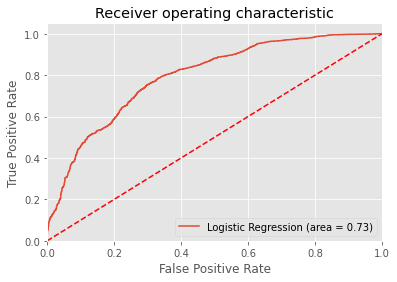

In [123]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()